# Initialize Workspace

In [ ]:
!pip install neurokit2
!pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.2/689.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

# Basic Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from math import floor
import scipy as scipy
import librosa as lbr
import neurokit2 as nk
import pandas as pd
import plotly.express as px
import itertools
import graphviz
import xgboost as xgb
import gc

# Scikit-Learn and Scipy Modules
import seaborn as sns
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from functools import reduce


from scipy.signal import savgol_filter,iirnotch,lfilter,butter,savgol_coeffs,freqz,find_peaks,resample,welch,periodogram,resample_poly,decimate
from scipy import signal
from scipy.stats import linregress, pearsonr, chisquare, chi2
from scipy.signal import firwin, kaiser_atten, kaiser_beta, lfilter,detrend

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM,Conv2D,Conv1D,Bidirectional,Reshape
from keras import backend as K

# ECG Modules
import biosppy

sns.set(font_scale=1.3)
sns.set_style("white")

In [ ]:
# Mount Google Drive
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Set Google Drive Path
libpath = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/'

# Import Custom Helper Modules
sys.path.append(libpath+'libs/')

from SQIs import apply_sqi,apply_gen_sqi
from pre_processing import data_normalize, up_sampling_data
from generate_dataset import get_dataset_DHMC, get_spirometry_vals,get_dataset_Matlab,get_dataset_PaperTubes,get_dataset_PlasticTubes
from feature_extractor import get_hand_features
from utilities import get_per_subject_data, edr_neurokit,get_subj_fev1

In [ ]:
# Useful directories
datapath_dir = '/content/drive/My Drive/HeartFEV1 Project/Data/DHMC_Data/dataset/'
saved_models = '/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/'

In [ ]:
# Initialize Variables
Fs_ppg = 54
Fs_resp = 20
Fs_ecg = 300
Fs_ppg_up = 60

LIMIT1 = 1.0 # 2.0 # 1.0 # 1.25
LIMIT2 = 1.5 # 2.75 # 1.5 # 1.54
LIMIT3 =  2.0 # 3.0 # 2.00 #2.40

# Trained model to generate pulse wave from peaks and valleys
model_classifier_ecg_board = tf.keras.models.load_model(saved_models+'221030_210932.h5')

In [ ]:
def data_preprocess(ECG_data,RESP_data,subjects_in,fs_resp,fs_ecg):
  # Normalize data
  RESP_in = data_normalize(RESP_data.reshape(RESP_data.shape[0],RESP_data.shape[1],1))
  ECG_in = data_normalize(ECG_data.reshape(ECG_data.shape[0],ECG_data.shape[1],1))

  # Apply SQI
  bd_windows = apply_gen_sqi(RESP_in,ECG_in,fs_resp,fs_ecg)

  # Remove bad data
  ECG_out = np.delete(ECG_in,bd_windows,0)
  RESP_out = np.delete(RESP_in,bd_windows,0)
  subjects_left = np.delete(subjects_in,bd_windows,0)
  return ECG_out,RESP_out,subjects_left

In [ ]:
def data_preprocess_DHMC(ECG_data,RESP_data,PPG_data,fev1_in,fvc_in,bmi_in,subjects_in,fs_resp,fs_ecg,PPG_input=False):
  # Normalize and up-sample PPG
  PPG_data_bw_90 = up_sampling_data(PPG_data.reshape(PPG_data.shape[0],PPG_data.shape[1],1),RESP_data.shape[1]*3)
  PPG_in = data_normalize(PPG_data_bw_90)
  RESP_in = data_normalize(RESP_data.reshape(RESP_data.shape[0],RESP_data.shape[1],1))
  ECG_in = data_normalize(ECG_data.reshape(ECG_data.shape[0],ECG_data.shape[1],1))

  # Apply SQI
  bd_windows = apply_sqi(RESP_in,ECG_in,fs_resp,fs_ecg,PPG_input)
  print(bd_windows)
  # Remove bad data
  ECG_dhmc = np.delete(ECG_in,bd_windows,0)
  if PPG_input:
    PPG_dhmc = np.delete(PPG_in,bd_windows,0)
  else:
    PPG_dhmc = PPG_in
  RESP_dhmc = np.delete(RESP_in,bd_windows,0)
  subjects_left_dhmc = np.delete(subjects_in,bd_windows,0)
  fev1_dhmc = np.delete(fev1_in,bd_windows,0)
  fvc_dhmc = np.delete(fvc_in,bd_windows,0)
  bmi_dhmc = np.delete(bmi_in,bd_windows,0)
  return ECG_dhmc,PPG_dhmc,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc

In [ ]:
def summarize_features(x_test_feat):
  feature_names = ['IER_med','RR_med','TA_med','S_med','SE_med','DFA_med','IRA_med','ERA_med', 'EA1_med',
          'IER_rms','RR_rms','TA_rms','S_rms','SE_rms','DFA_rms','IRA_rms','ERA_rms', 'EA1_rms',
          'IER_var','RR_var','TA_var','S_var','SE_var','DFA_var','IRA_var','ERA_var', 'EA1_var']
  x_test_feat_new_med,y_test_class_new,y_test_fvc_new, y_test_bmi_new, y_test_subjects_new = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects)
  x_test_feat_new_rms,_,_,_,_ = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects,'RMS')
  x_test_feat_new_var,_,_,_,_ = get_per_subject_data(x_test_feat,y_test,y_test_fvc,y_test_bmi,y_test_subjects,'var')
  x_test_feat_new = np.concatenate((x_test_feat_new_med,x_test_feat_new_rms,x_test_feat_new_var),axis=1)
  return x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,feature_names


In [ ]:
# Compute correlation
def fev1_fvc_correlation(features_in,fev1_vals,fvc_vals):
  data_in = np.concatenate((fev1_vals.reshape(fev1_vals.shape[0],1),features_in),axis=1)
  y_d_dhmc_fev1 = pd.DataFrame(data_in, columns=['FEV1']+cols_N)
  data_in = np.concatenate((fvc_vals.reshape(fvc_vals.shape[0],1),features_in),axis=1)
  y_d_dhmc_fvc = pd.DataFrame(data_in, columns=['FVC']+cols_N)
  y_d_fev1 = pd.concat([abs(y_d_dhmc_fev1.corr().iloc[0,1:]),abs(y_d_dhmc_fvc.corr().iloc[0,1:])],axis=1,keys=['FEV1','FVC'])
  y_d_fev1.plot.bar(figsize=[10,4],ylim=[0,1.0])
  plt.ylabel('abs(r)')
  plt.xlabel('Respiratory Features')
  plt.title('Correlation between FEV1,FVC and respiratory features')
  plt.grid()
  plt.show()
  return

In [ ]:
# Select 7 best features
def select_n_best_features(features_in,lung_func_param,subjects_in,num_feats=6):
  start_update = 0
  idxs_gd=[]
  while start_update <= num_feats:
    best_r2 = 0.0
    best_feat = []
    for idxs_in in [x for x in range(features_in.shape[1]) if x not in idxs_gd]:
      idxs = [idxs_in]
      x_test_feat_new_idx = features_in[:,idxs]
      unique_test_subjs = np.unique(subjects_in)
      y_predicted = np.zeros_like(lung_func_param)
      y_true =  lung_func_param

      # Perform Manual Leave-One Out
      for m in range(len(unique_test_subjs)):
        test_subj = unique_test_subjs[m]
        # print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
        idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
        idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
        x_train = x_test_feat_new_idx[idx_nottest_subj]
        x_test = x_test_feat_new_idx[idx_test_subj]
        y_train_model = lung_func_param[idx_nottest_subj]
        y_test_model = lung_func_param[idx_test_subj]
        scaler = StandardScaler().fit(x_train)
        x_train_norm = scaler.transform(x_train)
        x_test_norm = scaler.transform(x_test)
        model = tree.DecisionTreeRegressor(random_state=3)
        model.fit(x_train_norm, y_train_model)
        y_predicted[idx_test_subj] = model.predict(x_test_norm)

      slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
      r_sq_rr = r_rr**2
      # Percent error
      percent_error = np.mean(100*abs((y_predicted-y_true)/y_true))
      if r_rr > best_r2:
        best_r2 = r_rr
        best_feat = idxs

    idxs_gd = idxs_gd + best_feat
    start_update += 1
  return idxs_gd

In [ ]:
# Select best feature combination
def select_best_combination(features_in,lung_func_param,subjects_in,idxs_gd):
  best_r2 = 0.0
  best_feat = []
  for z in range(2,len(idxs_gd)):
    perm_r = itertools.combinations(idxs_gd, z)
    v_l = list(perm_r)
    for w in range(len(v_l)):
      idxs = v_l[w]
      x_test_feat_new_idx = features_in[:,idxs]
      unique_test_subjs = np.unique(subjects_in)
      y_predicted = np.zeros_like(lung_func_param)
      y_true =  lung_func_param

      # Perform Manual Leave-One Out
      for m in range(len(unique_test_subjs)):
        test_subj = unique_test_subjs[m]
        # print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
        idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
        idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
        x_train = x_test_feat_new_idx[idx_nottest_subj]
        x_test = x_test_feat_new_idx[idx_test_subj]
        y_train_model = lung_func_param[idx_nottest_subj]
        y_test_model = lung_func_param[idx_test_subj]
        scaler = StandardScaler().fit(x_train)
        x_train_norm = scaler.transform(x_train)
        x_test_norm = scaler.transform(x_test)
        model = tree.DecisionTreeRegressor(random_state=3)
        model.fit(x_train_norm, y_train_model)
        y_predicted[idx_test_subj] = model.predict(x_test_norm)

      slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
      r_sq_rr = r_rr**2
      # Percent error
      percent_error = np.mean(100*abs((y_predicted-y_true)/y_true))
      if r_rr > best_r2:
        best_r2 = r_rr
        best_feat = idxs
  return best_feat

In [ ]:
def feature_selection(features_in,lung_func_param,subjects_in):
  n_features = select_n_best_features(features_in,lung_func_param,subjects_in)
  features_selected = select_best_combination(features_in,lung_func_param,subjects_in,n_features)
  return features_selected

In [ ]:
def model_train_eval(features_in,lung_func_param,subjects_in,selected_feats):
  x_test_feat_new_idx = features_in[:,selected_feats]
  unique_test_subjs = np.unique(subjects_in)
  y_predicted = np.zeros_like(lung_func_param)
  y_true =  lung_func_param
  feat_importances = np.zeros((len(unique_test_subjs),x_test_feat_new_idx.shape[1]))
  # Perform Manual Leave-One Out
  for m in range(len(unique_test_subjs)):
    test_subj = unique_test_subjs[m]
    #print('m = ',m+1,' of ',len(unique_test_subjs),', subj = ',test_subj)
    idx_test_subj = np.argwhere(subjects_in==test_subj)[:,0]
    idx_nottest_subj = np.argwhere(subjects_in!=test_subj)[:,0]
    x_train = x_test_feat_new_idx[idx_nottest_subj]
    x_test = x_test_feat_new_idx[idx_test_subj]
    y_train_model = lung_func_param[idx_nottest_subj]
    y_test_model = lung_func_param[idx_test_subj]
    scaler = StandardScaler().fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)
    model = tree.DecisionTreeRegressor(random_state=3)
    model.fit(x_train_norm, y_train_model)
    y_predicted[idx_test_subj] = model.predict(x_test_norm)
    feat_importances[m,:] = model.feature_importances_
  return y_true,y_predicted,feat_importances

In [ ]:
# Performance Metrics
def performance_visualize(y_true,y_pred,feat_importances,selected_feats,feature_names,feat):
  # Feature Importance
  feat_avg = np.mean(feat_importances,axis=0,keepdims=True)
  feat_import = np.concatenate((feat_importances,feat_avg),axis=0)
  df_feat_import = pd.DataFrame(np.round(feat_import,2), columns=[feature_names[m] for m in selected_feats])
  ax = df_feat_import.iloc[15].plot.bar(figsize=[4,4],ylim=[0,1.0])
  for container in ax.containers:
      ax.bar_label(container)
  plt.grid('on')
  plt.title(feat)
  plt.ylabel('Feature Importance')
  plt.xlabel('Selected Feature Combination')
  plt.show()
  # Prediction Performance
  slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_pred)
  r_sq_rr = r_rr**2
  # Percent error
  percent_error = np.mean(100*abs((y_pred-y_true)/y_true))
  print('Percentage error = ',np.round(percent_error,2),'%')
  plt.plot(y_true,y_pred,'*')
  plt.xlabel('True '+feat)
  plt.ylabel('Predicted '+feat)
  plt.title('r = '+str(np.round(r_rr,2))+', R^2 = '+str(np.round(r_sq_rr,2))+', mape = '+str(np.round(percent_error,2))+'%')
  plt.show()
  return

In [ ]:
def quantize_fev1_class(nums,lim1 =LIMIT1,lim2=LIMIT2, lim3=LIMIT3):
  classes_out = np.zeros_like(nums)-1000
  for i in range(len(nums)):
    if nums[i] <= lim1:
      classes_out[i] = 0
    elif (nums[i]> lim1) and (nums[i]<=lim2):
      classes_out[i] = 1
    elif (nums[i]> lim2) and (nums[i]<=lim3):
      classes_out[i] = 2
    elif nums[i]>lim3:
      classes_out[i] = 3
    else:
      print('Bloody hell')
  return classes_out

In [ ]:
def get_sample_weights(y_in):
  y_input = quantize_fev1_class(y_in)
  class_wt = compute_class_weight(class_weight='balanced',classes=np.unique(y_input),y=y_input)
  sample_weights = np.zeros((y_in.shape[0],))
  for j in range(y_input.shape[0]):
    if y_input[j]==0:
      sample_weights[j] = class_wt[0]
    elif y_input[j]==1:
      sample_weights[j] = class_wt[1]
    elif y_input[j]==2:
      sample_weights[j] = class_wt[2]
    elif y_input[j]==3:
      sample_weights[j] = class_wt[3]
    else:
      raise SystemError('Unknown class')
  return sample_weights

In [ ]:
def visualize_results(y_true,y_predicted,title_in):
  slope_rr, intercept_rr, r_rr, p_val_r, se_rr = linregress(y_true,y_predicted)
  r_sq_rr = r_rr**2
  sns.set(font_scale=1.3)
  sns.set_style("white")
  plt.plot(y_true,y_predicted,'*')
  plt.xlabel('True FEV1')
  plt.ylabel('Predicted FEV1')
  plt.title(title_in+': r = '+str(np.round(r_rr,2))+', R^2 = '+str(np.round(r_sq_rr,2)))
  plt.show()
  return

# Load Matlab ECG Data

In [ ]:
ECG_set,RESP_set,RR_set,subjects,test_idx1,val_idx = get_dataset_Matlab()

In [ ]:
print('ECG DATA SET SIZE = ',ECG_set.shape)
print('RESP DATA SET SIZE = ',RESP_set.shape)
print('RR DATA SET SIZE = ',RR_set.shape)
print('SUBJECT SET SIZE = ',subjects.shape)

ECG DATA SET SIZE =  (659, 27000)
RESP DATA SET SIZE =  (659, 1800)
RR DATA SET SIZE =  (659, 1800)
SUBJECT SET SIZE =  (659,)


In [ ]:
ECG_matlab,RESP_matlab,subjects_left_matlab = data_preprocess(ECG_set,RESP_set,subjects,Fs_resp,Fs_ecg)
print(ECG_matlab.shape,RESP_matlab.shape,subjects_left_matlab.shape)

/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/libs/pre_processing.py:12: RuntimeWarning: invalid value encountered in divide
  data_out = (data_in-min_in)/(max_in-min_in)
/content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/libs/SQIs.py:16: RuntimeWarning: invalid value encountered in divide
  data_out = (data_in-min_in)/(max_in-min_in)


(414, 27000, 1) (414, 1800, 1) (414,)


# Load Simulated Paper Tube ECG and RESP Data

In [ ]:
ECG_data,RESP_data,PPG_data,subjects_sim,no_tube,open_tube,one_hole,five_hole = get_dataset_PaperTubes()

In [ ]:
ECG_tube,RESP_tube,subjects_left_tube = data_preprocess(ECG_data,RESP_data,subjects_sim,Fs_resp,Fs_ecg)
print(ECG_tube.shape,RESP_tube.shape,subjects_left_tube.shape)

(215, 27000, 1) (215, 1800, 1) (215,)


# Load Spirometry Simulated Data

In [ ]:
ECG_data,RESP_data,PPG_data,subjects_sim,normal,mild,moderate,severe,very_severe = get_dataset_PlasticTubes()

In [ ]:
print(len(normal)+len(mild)+len(moderate)+len(severe)+len(very_severe))
print(len(np.unique(np.concatenate((normal,mild,moderate,severe,very_severe)))))

227
227


In [ ]:
ECG_sim,RESP_sim,subjects_left_sim = data_preprocess(ECG_data,RESP_data,subjects_sim,Fs_resp,Fs_ecg)
print(ECG_sim.shape,RESP_sim.shape,subjects_left_sim.shape)

(146, 27000, 1) (146, 1800, 1) (146,)


# Load DHMC Dataset

In [ ]:
ECG_data,RESP_data,_,subjects_dhmc = get_dataset_DHMC()
ECG_data_ppg,RESP_data_ppg,PPG_data,subjects_dhmc_ppg = get_dataset_DHMC(True)

print(ECG_data.shape, RESP_data.shape, len(subjects_dhmc))
print(ECG_data_ppg.shape, RESP_data_ppg.shape,PPG_data.shape,len(subjects_dhmc_ppg))

(148, 27000) (148, 1800) 148
(121, 27000) (121, 1800) (121, 4860) 121


In [ ]:
fev1,fvc,bmi = get_spirometry_vals(subjects_dhmc)
fev1_ppg,fvc_ppg,bmi_ppg = get_spirometry_vals(subjects_dhmc_ppg)
print(fev1.shape,fvc.shape,bmi.shape)
print(fev1_ppg.shape,fvc_ppg.shape,bmi_ppg.shape)

(148,) (148,) (148,)
(121,) (121,) (121,)


In [ ]:
ECG_dhmc,_,RESP_dhmc,subjects_left_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc = data_preprocess_DHMC(ECG_data,RESP_data,PPG_data,fev1,fvc,bmi,subjects_dhmc,Fs_resp,Fs_ecg,False)
print(len(subjects_left_dhmc),ECG_dhmc.shape,RESP_dhmc.shape,fev1_dhmc.shape,fvc_dhmc.shape,bmi_dhmc.shape,len(np.unique(subjects_left_dhmc)), len(np.unique(subjects_dhmc)))

[  7   8   9  16  22  24  25  26  27  28  30  33  34  35  36  37  38  39
  45  46  52  55  64  77  78  80  82  85  91  92  93  94  95  96  99 100
 106 108 109 118 119 120 121 122 125 134 139 141]
100 (100, 27000, 1) (100, 1800, 1) (100,) (100,) (100,) 24 25


# Extract EDR Signal

## Create Datasets

In [72]:
x_train = np.concatenate((ECG_matlab,ECG_tube,ECG_sim),axis=0)
y_train = np.concatenate((RESP_matlab,RESP_tube,RESP_sim),axis=0)

x_test = ECG_dhmc
y_test = RESP_dhmc

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(775, 27000, 1) (775, 1800, 1) (100, 27000, 1) (100, 1800, 1)


## Training

In [73]:
loss_fn = 'mse'
lr = 0.01
batch_size = 128
num_epochs = 1000 # Use this -> 1000
moniker = 'worst_case_'

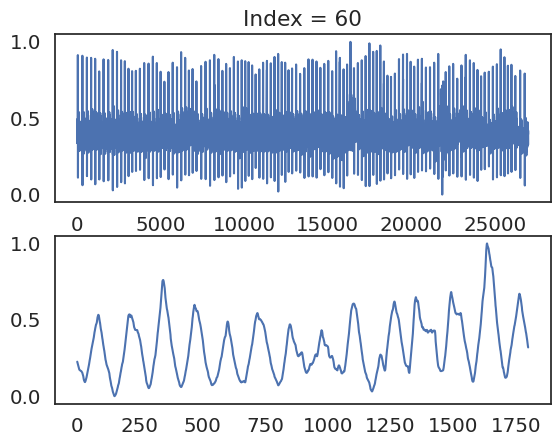

In [74]:
# Visualize D1 data
idx = 60
plt.figure()
plt.subplot(211)
plt.title('Index = '+str(idx))
plt.plot(x_train[idx,:,0])
plt.subplot(212)
plt.plot(y_train[idx,:,0])
plt.show()

In [75]:
# Multi-task NN
x_input = layers.Input(shape=(x_train.shape[1],x_train.shape[2]),name='inputs')

# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)

# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)

# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
model.compile(optimizer=adam, loss={'regression':'mse'})
model.summary()

# Compile the model
model.load_weights(saved_models+'230620_144409_2.hdf5') # 230620_144409_2 , 240206_162411
model.compile(optimizer=adam, loss={'regression':'mse'})

# checkpoint
now = datetime.datetime.now()
s1 = now.strftime("%y%m%d_%H%M%S")
filepath_edr = (saved_models+moniker+s1+'.hdf5')
checkpoint = ModelCheckpoint(filepath_edr, monitor='loss', verbose=1, save_best_only=True, mode='min')
early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
callbacks_list = [checkpoint]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 27000, 1)]        0         
                                                                 
 conv1d_10 (Conv1D)          (None, 9000, 8)           48        
                                                                 
 conv1d_11 (Conv1D)          (None, 1800, 4)           228       
                                                                 
 bidirectional_10 (Bidirect  (None, 1800, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 1800, 16)          2016      
 ional)                                                          
                                                                 
 dense_5 (Dense)             (None, 1800, 2)           34  

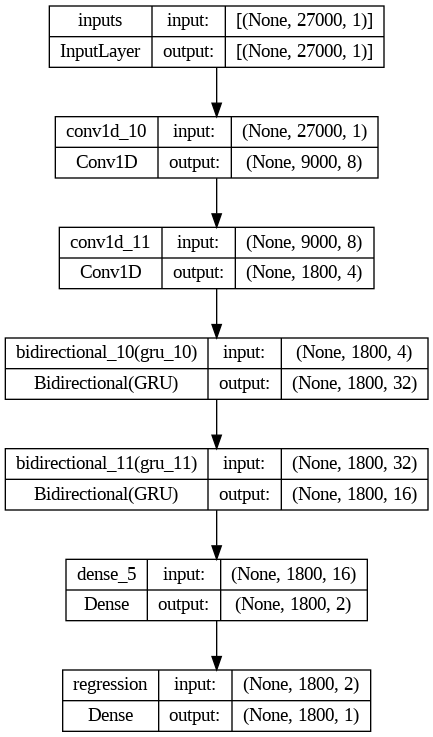

In [76]:
# Plot the model
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [ ]:
history = model.fit({'inputs':x_train},{'regression':y_train},epochs=num_epochs,batch_size=batch_size,shuffle=True,
                    verbose=True,callbacks=callbacks_list)

Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 0.0671
Epoch 1: loss improved from inf to 0.06707, saving model to /content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/worst_case_240623_151234.hdf5
7/7 [==============================] - 21s 456ms/step - loss: 0.0671
Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.0655
Epoch 2: loss improved from 0.06707 to 0.06550, saving model to /content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/worst_case_240623_151234.hdf5
7/7 [==============================] - 3s 428ms/step - loss: 0.0655
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.0635
Epoch 3: loss improved from 0.06550 to 0.06354, saving model to /content/drive/My Drive/HeartFEV1 Project/Signal Processing and Machine Learning Code/saved_models/worst_case_240623_151234.hdf5
7/7 [==============================] - 1s 184ms/step - loss: 0.

In [ ]:
# Visualize the model
N = num_epochs
# plt.style.use("ggplot")
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Regression Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='center right')
plt.show()

## Results

In [ ]:
# Compile the model
model.load_weights(filepath_edr)
model.compile(optimizer=adam, loss={'regression':'mse'})
# model.save(modelpath+s1+'.h5')
print(filepath_edr)

### Train set

In [ ]:
# Test model
results_train = model.evaluate({'inputs':x_train},{'regression':y_train},batch_size=batch_size,verbose = 1)
print(results_train)

y_pred_resp = model.predict({'inputs':x_train})

In [ ]:
# Normalize
y_train_r = data_normalize(y_train)
y_pred_resp = data_normalize(y_pred_resp)

In [ ]:
z = 0
plt.figure(figsize=(10,6))
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
z = 144
plt.figure(figsize=(10,6))
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
z = 200
plt.figure(figsize=(10,6))
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
z = 81
plt.figure(figsize=(10,6))
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
gg = 40
z = gg
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(x_train[z,:,:],label='ECG')
plt.legend()
plt.subplot(212)
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
z = gg - 29
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(x_train[z,:,:],label='ECG')
plt.legend()
plt.subplot(212)
plt.plot(y_train[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

### Test set

In [ ]:
# Compile the model
model.load_weights(filepath_edr)
model.compile(optimizer=adam, loss={'regression':'mse'})
# model.save(modelpath+s1+'.h5')
print(filepath_edr)

In [ ]:
# Test model
results_test = model.evaluate({'inputs':x_test},{'regression':y_test},batch_size=batch_size,verbose = 1)
print(results_test)

y_pred_resp = model.predict({'inputs':x_test})

In [ ]:
y_test_r = data_normalize(y_test)
y_pred_resp = data_normalize(y_pred_resp)

In [ ]:
t = np.arange(0,y_test_r.shape[1])/Fs_resp
z = 0
sns.set(font_scale=1.3)
sns.set_style("white")
plt.figure(figsize=(15,4))
plt.plot(t,y_test[z,:,:],label='true',linewidth=3)
plt.plot(t,y_pred_resp[z,:,:],label='predicted',linewidth=3)
plt.xlabel('Time in seconds')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.show()

In [ ]:
z = 10
plt.figure(figsize=(10,6))
plt.plot(y_test[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
z = 2
plt.figure(figsize=(10,6))
plt.plot(y_test[z,:,:],label='true')
plt.plot(y_pred_resp[z,:,:],label='predicted')
plt.legend()
plt.show()

In [ ]:
print(x_test.shape,y_test.shape,y_pred_resp.shape,subjects_left_dhmc.shape)

# Estimate FEV1 from EDR Signal - Feature Extraction

In [ ]:
# Extract EDR and PDR signals
# EDR Model
x_input = layers.Input(shape=(None,1),name='inputs')
# CNN Layers
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# GRU Layer
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting
model = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=adam, loss={'regression':'mse'})
model.load_weights(filepath_edr) # saved_models+'worst_case_240207_200203.hdf5') #
model.compile(optimizer=adam, loss={'regression':'mse'})
EDR_in = model.predict({'inputs':data_normalize(ECG_dhmc)})
EDR_dhmc = data_normalize(EDR_in)

4/4 [==============================] - 3s 301ms/step


In [ ]:
# Define Data
x_test,y_test,y_test_fvc,y_test_bmi,y_test_subjects = EDR_dhmc,fev1_dhmc,fvc_dhmc,bmi_dhmc,subjects_left_dhmc
sq_pr1 = model_classifier_ecg_board.predict(data_normalize(x_test))
x_test_class = sq_pr1.round()

4/4 [==============================] - 1s 145ms/step


In [ ]:
# Get hand engineered features
x_test_handfeat = get_hand_features(x_test, x_test_class,y_test_bmi,Fs_resp)
x_test_handfeat = np.nan_to_num(x_test_handfeat,nan=0,posinf=None,neginf=None)
# Summarization step - per subject
x_test_feat_new,y_test_class_new,y_test_fvc_new,y_test_bmi_new,y_test_subjects_new,cols_N = summarize_features(x_test_handfeat)
print(x_test_feat_new.shape,y_test_class_new.shape,y_test_fvc_new.shape,y_test_bmi_new.shape,y_test_subjects_new.shape)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(24, 27) (24,) (24,) (24,) (24,)


## Visualize feature correlations

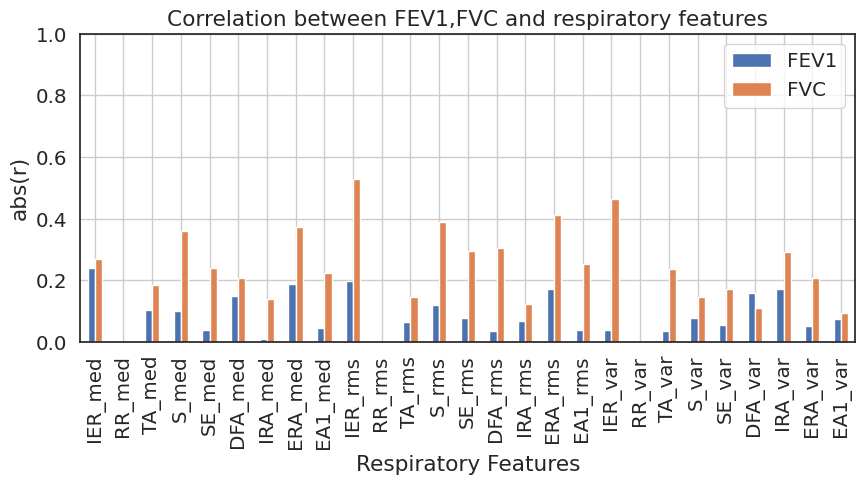

In [ ]:
fev1_fvc_correlation(x_test_feat_new,y_test_class_new,y_test_fvc_new)

## Model Selection

In [ ]:
fev1_features = feature_selection(x_test_feat_new,y_test_class_new,y_test_subjects_new)
fvc_features = feature_selection(x_test_feat_new,y_test_fvc_new,y_test_subjects_new)
print(fev1_features, fvc_features)

(0, 15) (13, 25, 17)


In [ ]:
print('FEV1 Feature Combination:', [cols_N[m] for m in fev1_features])
print('FVC Feature Combination:', [cols_N[m] for m in fvc_features])

FEV1 Feature Combination: ['IER_med', 'IRA_rms']
FVC Feature Combination: ['SE_rms', 'ERA_var', 'EA1_rms']


## Model Training and LOSO Evaluation

In [ ]:
# FEV1 Performance
y_true_fev1,y_predicted_fev1,feat_importances_fev1 = model_train_eval(x_test_feat_new,y_test_class_new,y_test_subjects_new,fev1_features)
# FVC Performance
y_true_fvc,y_predicted_fvc,feat_importances_fvc = model_train_eval(x_test_feat_new,y_test_fvc_new,y_test_subjects_new,fvc_features)

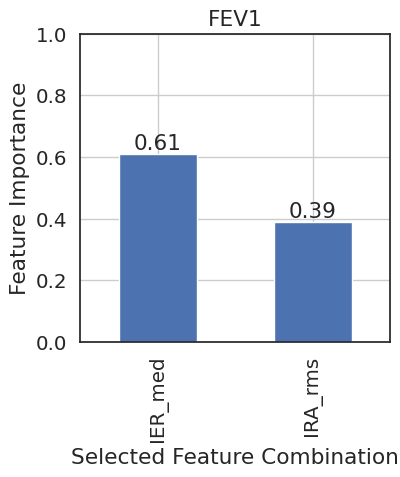

Percentage error =  30.19 %


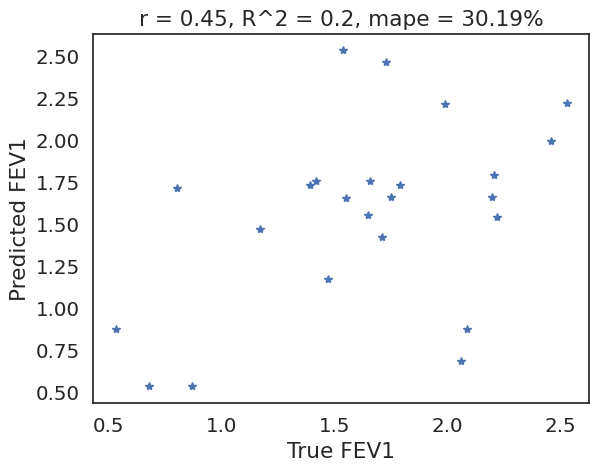

In [ ]:
performance_visualize(y_true_fev1,y_predicted_fev1,feat_importances_fev1,fev1_features,cols_N,'FEV1')

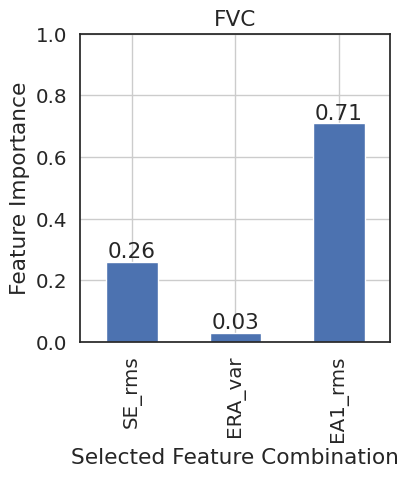

Percentage error =  31.97 %


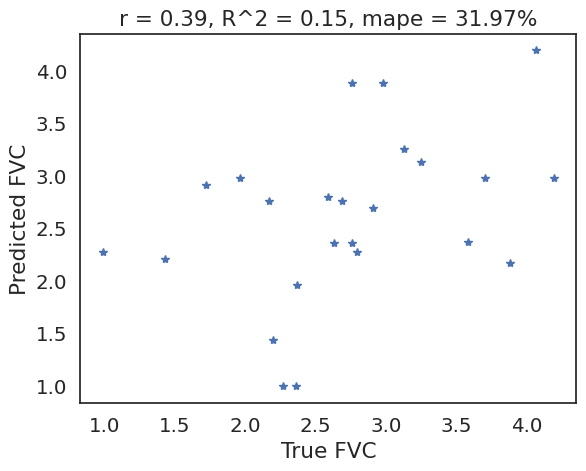

In [ ]:
performance_visualize(y_true_fvc,y_predicted_fvc,feat_importances_fvc,fvc_features,cols_N,'FVC')

# Estimate FEV1 from ECG Signal using Residual Neural Network - FEV1 Estimator

In [ ]:
num_epochs = 2 # Use this -> 500
batch_size = 64 # Use this -> 8
lr = 0.0001
loss_fn = 'mse'

LIMIT1 = 1.0 # 2.0 # 1.0 # 1.25
LIMIT2 = 1.5 # 2.75 # 1.5 # 1.54
LIMIT3 =  2.0 # 3.0 # 2.00 #2.40

In [ ]:
x_test,y_test_r,y_test_fev,y_test_subj = ECG_dhmc,RESP_dhmc,fev1_dhmc,subjects_left_dhmc

print(x_test.shape,y_test_r.shape,y_test_fev.shape,y_test_subj.shape)

(100, 27000, 1) (100, 1800, 1) (100,) (100,)


## Create inputs

In [ ]:
# Initialize EDR signal
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
# Linear regression
dense_reg = layers.Dense(2, activation='swish')(clss_2)
reg_pred = layers.Dense(1, activation='linear',name='regression')(dense_reg)
# Instantiate an end-to-end model predicting both priority and department
model_edr = keras.Model(inputs=[x_input], outputs=[reg_pred])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_edr.compile(optimizer=adam, loss={'regression':'mse'})
model_edr.summary()
# Compile the model
model_edr.load_weights(filepath_edr) # saved_models+'worst_case_240207_200203.hdf5')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_13 (Conv1D)          (None, None, 4)           228       
                                                                 
 bidirectional_10 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, None, 2)           34  

In [ ]:
# Model 1
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
model1 = keras.Model(inputs=[x_input], outputs=[cnn2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model1.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model1.layers[1].set_weights(model_edr.layers[1].get_weights())
model1.layers[2].set_weights(model_edr.layers[2].get_weights())
model1.layers[1].trainable = False
model1.layers[2].trainable = False
model1.summary()

cnn2_in = model1.predict(x_test)
print(cnn2_in.shape)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_15 (Conv1D)          (None, None, 4)           228       
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 276 (1.08 KB)
_________________________________________________________________
4/4 [==============================] - 0s 22ms/step
(100, 1800, 4)


In [ ]:
# Model 2
x_input = layers.Input(shape=(None,x_test.shape[2]),name='inputs')
# Feature Extractor
cnn1 = layers.Conv1D(8,5,padding='same',strides=3,activation='relu')(x_input)
cnn2 = layers.Conv1D(4,7,padding='same',strides=5,activation='relu')(cnn1)
# Classifier layer 1
clss_1 = layers.Bidirectional(layers.GRU(16,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(cnn2)
clss_2 = layers.Bidirectional(layers.GRU(8,activation='tanh', recurrent_activation='sigmoid',return_sequences=True))(clss_1)
model2 = keras.Model(inputs=[x_input], outputs=[clss_2])
adam = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=adam, loss={'regression':'mse'})
# Initialize EDR Algorithm weights
model2.layers[1].set_weights(model_edr.layers[1].get_weights())
model2.layers[2].set_weights(model_edr.layers[2].get_weights())
model2.layers[3].set_weights(model_edr.layers[3].get_weights())
model2.layers[4].set_weights(model_edr.layers[4].get_weights())
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[3].trainable = False
model2.layers[4].trainable = False
model2.summary()

clss_2_in = model2.predict(x_test)
print(clss_2_in.shape)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 1)]         0         
                                                                 
 conv1d_16 (Conv1D)          (None, None, 8)           48        
                                                                 
 conv1d_17 (Conv1D)          (None, None, 4)           228       
                                                                 
 bidirectional_12 (Bidirect  (None, None, 32)          2112      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, None, 16)          2016      
 ional)                                                          
                                                                 
Total params: 4404 (17.20 KB)
Trainable params: 0 (0.00 Byt

In [ ]:
reg_pred_in = model_edr.predict(x_test)
print(reg_pred_in.shape)

4/4 [==============================] - 3s 322ms/step
(100, 1800, 1)


In [ ]:
x_test_new = np.concatenate((cnn2_in,clss_2_in,reg_pred_in),axis=2)
print(x_test_new.shape)

(100, 1800, 21)


## Perfect Case

In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240515_205445


In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  model.summary()

  # checkpoint
  now = datetime.datetime.now()
  s1 = now.strftime("%y%m%d_%H%M%S")
  filepath= ('resp_'+fold+'_'+s1+'.hdf5')
  checkpoint = ModelCheckpoint(filepath, monitor='val_'+loss_fn, verbose=1, save_best_only=True, mode='min')
  early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
  callbacks_list = [checkpoint]
  samp_wt = get_sample_weights(data_train_fev1)

  # Train model
  history = model.fit({'inputs':data_train_x},{'fev1':data_train_fev1},epochs=num_epochs,batch_size=batch_size,
                      validation_data=({'inputs':data_test_x},{'fev1':data_test_fev1}),shuffle=True,verbose=False,callbacks=callbacks_list,sample_weight=samp_wt)
  # Model Performance
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_20 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_2 (Bat  (None, 258, 10)           40        
 chNormalization)                                                
                                                                 
 conv1d_21 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_normalization_3 (Bat  (None, 37, 10)            40        
 chNormalization)                                                
                                                                 
 global_average_pooling1d_1  (None, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.3647
3.364675283432007
1/1 [==============================] - 0s 30ms/step - loss: 6.7486
6.748582363128662
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-003
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_22 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_4 (Bat  (None, 258, 10)           40        
 chNormalization)                                                
                                                                 
 conv1d_23 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma


Epoch 1: val_mse improved from inf to 2.44903, saving model to resp_c-003_240515_205449.hdf5

Epoch 2: val_mse improved from 2.44903 to 2.43969, saving model to resp_c-003_240515_205449.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 2.8192
2.819185256958008
1/1 [==============================] - 0s 24ms/step - loss: 2.4397
2.439685821533203
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-004
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_24 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_6 (Bat  (None, 258, 10)           40        
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.3889
3.3888823986053467
1/1 [==============================] - 0s 39ms/step - loss: 0.8317
0.8317360877990723
1/1 [==============================] - 0s 35ms/step
DHMC Subject =  c-007
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_26 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_8 (Bat  (None, 258, 10)           40        
 chNormalization)                                                
                                                                 
 conv1d_27 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 3.1012
3.1011955738067627
1/1 [==============================] - 0s 25ms/step - loss: 2.9750
2.975017547607422
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-008
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_28 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_10 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_29 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.4254
3.425394296646118
1/1 [==============================] - 0s 30ms/step - loss: 0.3513
0.35128965973854065
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-010
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_30 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_12 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_31 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 3.1232
3.123243570327759
1/1 [==============================] - 0s 25ms/step - loss: 2.9187
2.9187443256378174
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  c-011
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_32 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_14 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_33 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 20ms/step - loss: 3.2186
3.218554973602295
1/1 [==============================] - 0s 43ms/step - loss: 2.2056
2.2055699825286865
1/1 [==============================] - 0s 40ms/step
DHMC Subject =  c-012
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_34 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_16 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_35 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 14ms/step - loss: 3.2201
3.2200706005096436
1/1 [==============================] - 0s 27ms/step - loss: 0.4593
0.4592951238155365
1/1 [==============================] - 0s 117ms/step
DHMC Subject =  c-013
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_36 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_18 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_37 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_no

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 3.1115
3.1114609241485596


1/1 [==============================] - 0s 25ms/step - loss: 3.2036
3.2036073207855225
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-015
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_38 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_20 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_39 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_normalization_21 (Ba  (None, 37, 10)            40        
 tchNormalization)            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 13ms/step - loss: 2.8110
2.8109936714172363


1/1 [==============================] - 0s 26ms/step - loss: 6.2509
6.2509446144104
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  c-016
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_40 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_22 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_41 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_normalization_23 (Ba  (None, 37, 10)            40        
 tchNormalization)               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 20ms/step - loss: 2.8110
2.810981035232544
1/1 [==============================] - 0s 46ms/step - loss: 1.6617
1.6617486476898193
1/1 [==============================] - 0s 34ms/step
DHMC Subject =  c-017
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_42 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_24 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_43 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 2.7429
2.742870330810547
1/1 [==============================] - 0s 25ms/step - loss: 3.9459
3.9458587169647217
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-020
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_44 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_26 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_45 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 3.0249
3.0249412059783936
1/1 [==============================] - 0s 23ms/step - loss: 2.2901
2.290113687515259
1/1 [==============================] - 0s 106ms/step
DHMC Subject =  n-003
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_46 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_28 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_47 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 2.9586
2.9586429595947266
1/1 [==============================] - 0s 26ms/step - loss: 1.8546
1.8546009063720703
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  n-004
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_48 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_30 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_49 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 13ms/step - loss: 3.2813
3.281262159347534
1/1 [==============================] - 0s 38ms/step - loss: 4.1951
4.19509220123291
1/1 [==============================] - 0s 155ms/step
DHMC Subject =  n-005
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_50 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_32 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_51 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 2.7899
2.7898776531219482
1/1 [==============================] - 0s 26ms/step - loss: 4.5655
4.565549850463867
1/1 [==============================] - 0s 21ms/step
DHMC Subject =  n-006
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_52 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_34 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_53 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.2768
3.2767906188964844
1/1 [==============================] - 0s 28ms/step - loss: 2.4808
2.4808173179626465
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  n-007
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_54 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_36 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_55 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.8244
3.8243939876556396
1/1 [==============================] - 0s 27ms/step - loss: 1.7830
1.7830075025558472
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  n-009
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_56 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_38 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_57 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 24ms/step - loss: 3.3351
3.335108757019043
1/1 [==============================] - 0s 39ms/step - loss: 4.5536
4.553643703460693
1/1 [==============================] - 0s 31ms/step
DHMC Subject =  n-010
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_58 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_40 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_59 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 19ms/step - loss: 3.0235
3.0234873294830322
1/1 [==============================] - 0s 40ms/step - loss: 0.5718
0.5717973113059998
1/1 [==============================] - 0s 38ms/step
DHMC Subject =  n-012
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_60 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_42 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_61 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 2.9443
2.9443161487579346
1/1 [==============================] - 0s 27ms/step - loss: 4.7515
4.751473903656006
1/1 [==============================] - 0s 105ms/step
DHMC Subject =  n-013
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_62 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_44 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_63 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 2.5703
2.5702974796295166
1/1 [==============================] - 0s 27ms/step - loss: 2.4879
2.4878764152526855
1/1 [==============================] - 0s 25ms/step
DHMC Subject =  n-014
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_64 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_46 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_65 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 20ms/step - loss: 3.0190
3.019015312194824
1/1 [==============================] - 0s 40ms/step - loss: 4.7801
4.780132293701172
1/1 [==============================] - 0s 36ms/step
DHMC Subject =  n-015
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_66 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_48 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_67 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 2.7928
2.7928354740142822
1/1 [==============================] - 0s 28ms/step - loss: 2.3874
2.387441635131836
1/1 [==============================] - 0s 22ms/step


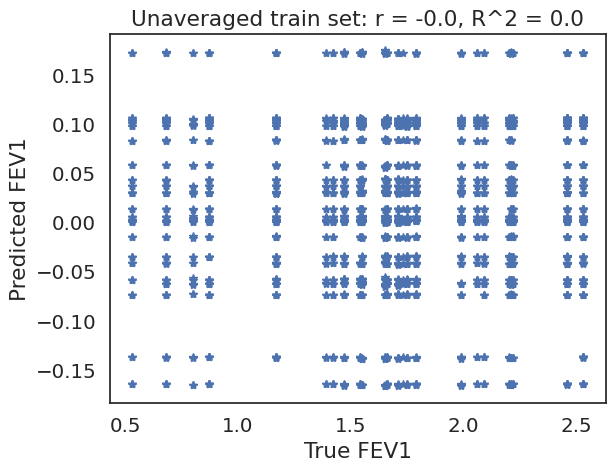

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

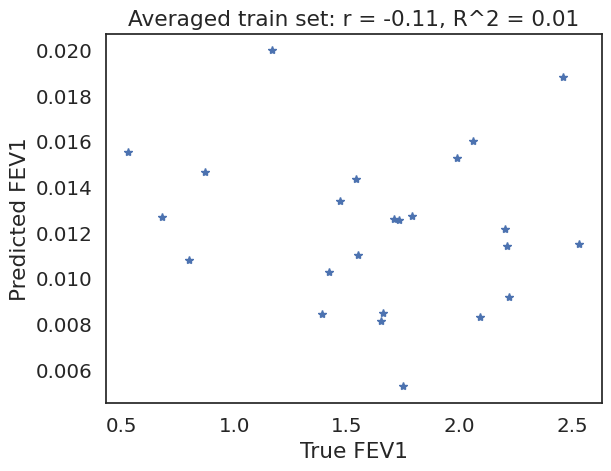

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

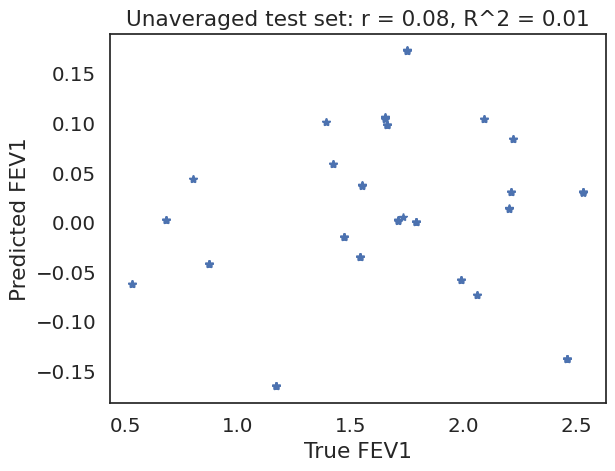

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

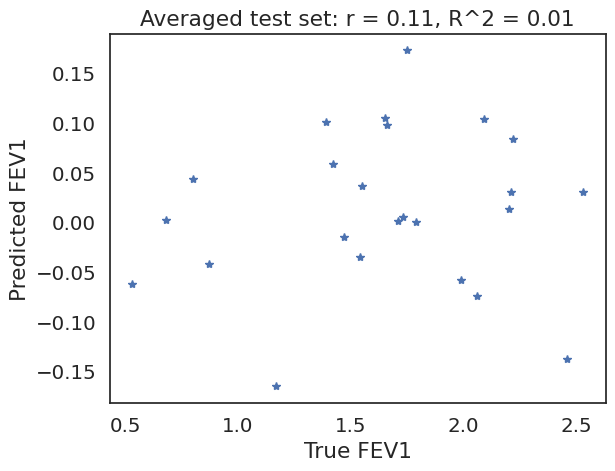

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

## Model

In [ ]:
y_train_fev1_true = []
y_train_fev1_pred = []
y_train_subj_pred = []

y_test_fev1_pred = np.zeros_like(y_test_fev)
subjects_fold = np.unique(y_test_subj)
y_test_fev1_pred_per_subject = np.zeros((len(subjects_fold),2))
m = 0
now = datetime.datetime.now()
date_n = now.strftime("%y%m%d_%H%M%S")
print(date_n)
data_modeled = 'edr_fev1_loso'

240515_210453


In [ ]:
subjects_fold

array(['c-002', 'c-003', 'c-004', 'c-007', 'c-008', 'c-010', 'c-011',
       'c-012', 'c-013', 'c-015', 'c-016', 'c-017', 'c-020', 'n-003',
       'n-004', 'n-005', 'n-006', 'n-007', 'n-009', 'n-010', 'n-012',
       'n-013', 'n-014', 'n-015'], dtype='<U5')

In [ ]:
for fold in subjects_fold:
  print('DHMC Subject = ',fold)

  # Create train, val and test data
  idx_test = np.argwhere(y_test_subj==fold)[:,0]
  idx_train = np.argwhere(y_test_subj!=fold)[:,0]
  data_test_x = x_test_new[idx_test]
  data_test_y = y_test_r[idx_test]
  data_test_fev1 = y_test_fev[idx_test]
  data_train_x = x_test_new[idx_train]
  data_train_y = y_test_r[idx_train]
  data_train_fev1 = y_test_fev[idx_train]
  data_train_subjects = y_test_subj[idx_train]

  # Initialize model
  x_input = layers.Input(shape=(data_train_x.shape[1],data_train_x.shape[2]),name='inputs')
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(x_input)
  batch_out = layers.BatchNormalization()(gru_out)
  gru_out = layers.Conv1D(10,9,activation='relu',strides=7,padding='same')(batch_out)
  batch_out = layers.BatchNormalization()(gru_out)
  pool1 = layers.GlobalAveragePooling1D()(batch_out)
  fev_pred = layers.Dense(1, activation='linear',name='fev1')(pool1)

  model = keras.Model(inputs=[x_input], outputs=[fev_pred])
  adam = tf.keras.optimizers.RMSprop(learning_rate=lr)
  model.compile(optimizer=adam,loss={'fev1':loss_fn},weighted_metrics=[loss_fn])
  model.summary()

  # checkpoint
  now = datetime.datetime.now()
  s1 = now.strftime("%y%m%d_%H%M%S")
  filepath= ('resp_'+fold+'_'+s1+'.hdf5')
  checkpoint = ModelCheckpoint(filepath, monitor='val_'+loss_fn, verbose=1, save_best_only=True, mode='min')
  early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
  callbacks_list = [checkpoint]
  samp_wt = get_sample_weights(data_train_fev1)

  # Train model
  history = model.fit({'inputs':data_train_x},{'fev1':data_train_fev1},epochs=num_epochs,batch_size=batch_size,
                      validation_split=0.2,shuffle=True,verbose=False,callbacks=callbacks_list)#,sample_weight=samp_wt)
  # Model Performance
  model.load_weights(filepath)
  model.compile(optimizer=adam, loss={'fev1':loss_fn})
  # Train set performance
  results_train = model.evaluate({'inputs':data_train_x},{'fev1':data_train_fev1},batch_size=batch_size,verbose = 1)
  print(results_train)
  y_train_pred_fev1 = model.predict(data_train_x)
  y_train_fev1_true.append(data_train_fev1)
  y_train_fev1_pred.append(y_train_pred_fev1[:,0])
  y_train_subj_pred.append(data_train_subjects)
  # Get average subject performance
  y_train_true = get_subj_fev1(data_train_fev1,data_train_subjects)
  y_train_predicted = get_subj_fev1(y_train_pred_fev1[:,0],data_train_subjects)
  # Compute regression
  slope_rr_train, intercept_rr_train, r_rr_train, p_val_r_train, se_rr_train = linregress(y_train_true,y_train_predicted)

  # Test set performance
  results_test = model.evaluate({'inputs':data_test_x},{'fev1':data_test_fev1},batch_size=batch_size,verbose = 1)
  print(results_test)
  y_test_pred_fev1 = model.predict(data_test_x)
  y_test_fev1_pred[idx_test] = y_test_pred_fev1[:,0]

  del model
  gc.collect()
  m = m+1

DHMC Subject =  c-002
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_68 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_50 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_69 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_normalization_51 (Ba  (None, 37, 10)            40        
 tchNormalization)                                               
                                                                 
 global_average_pooling1d_2  (None, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.1223
3.1223042011260986
1/1 [==============================] - 0s 31ms/step - loss: 6.3905
6.390467643737793
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-003
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_70 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_52 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_71 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 14ms/step - loss: 3.3668
3.3668296337127686
1/1 [==============================] - 0s 37ms/step - loss: 2.9788
2.97881817817688
1/1 [==============================] - 0s 37ms/step
DHMC Subject =  c-004
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_72 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_54 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_73 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.1103
3.1102564334869385
1/1 [==============================] - 0s 28ms/step - loss: 0.6916
0.6915649175643921
1/1 [==============================] - 0s 26ms/step
DHMC Subject =  c-007
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_74 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_56 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_75 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.0203
3.0203332901000977
1/1 [==============================] - 0s 32ms/step - loss: 2.8925
2.892524242401123
1/1 [==============================] - 0s 22ms/step
DHMC Subject =  c-008
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_76 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_58 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_77 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 2.5579
2.5578513145446777
1/1 [==============================] - 0s 27ms/step - loss: 0.1092
0.10924475640058517
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  c-010
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_78 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_60 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_79 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_no

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 17ms/step - loss: 2.4007
2.400665521621704
1/1 [==============================] - 0s 46ms/step - loss: 2.1850
2.1850321292877197
1/1 [==============================] - 0s 33ms/step
DHMC Subject =  c-011
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_80 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_62 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_81 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 13ms/step - loss: 3.5441
3.5440571308135986
1/1 [==============================] - 0s 26ms/step - loss: 2.4881
2.488137722015381
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  c-012
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_82 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_64 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_83 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.2580
3.2580184936523438
1/1 [==============================] - 0s 30ms/step - loss: 0.4743
0.47431617975234985
1/1 [==============================] - 0s 113ms/step
DHMC Subject =  c-013
Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_84 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_66 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_85 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_n

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.3561
3.3560967445373535
1/1 [==============================] - 0s 24ms/step - loss: 3.4650
3.4649903774261475
1/1 [==============================] - 0s 28ms/step
DHMC Subject =  c-015
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_86 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_68 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_87 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 19ms/step - loss: 2.9107
2.9107048511505127
1/1 [==============================] - 0s 38ms/step - loss: 6.4057
6.405667781829834
1/1 [==============================] - 0s 37ms/step
DHMC Subject =  c-016
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_88 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_70 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_89 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 2.9230
2.9229798316955566
1/1 [==============================] - 0s 23ms/step - loss: 1.7533
1.753325343132019
1/1 [==============================] - 0s 21ms/step
DHMC Subject =  c-017
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_90 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_72 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_91 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 14ms/step - loss: 2.6177
2.617675542831421
1/1 [==============================] - 0s 29ms/step - loss: 3.7885
3.7884864807128906
1/1 [==============================] - 0s 30ms/step
DHMC Subject =  c-020
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_92 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_74 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_93 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 10ms/step - loss: 2.9595
2.959538459777832
1/1 [==============================] - 0s 30ms/step - loss: 2.2330
2.2330315113067627
1/1 [==============================] - 0s 136ms/step
DHMC Subject =  n-003
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_94 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_76 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_95 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 14ms/step - loss: 3.0943
3.094282388687134
1/1 [==============================] - 0s 37ms/step - loss: 1.9678
1.9678115844726562
1/1 [==============================] - 0s 33ms/step
DHMC Subject =  n-004
Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_96 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_78 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_97 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.1595
3.1595237255096436
1/1 [==============================] - 0s 26ms/step - loss: 4.0520
4.051995277404785
1/1 [==============================] - 0s 115ms/step
DHMC Subject =  n-005
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_98 (Conv1D)          (None, 258, 10)           1900      
                                                                 
 batch_normalization_80 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_99 (Conv1D)          (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 2.4107
2.4107093811035156
1/1 [==============================] - 0s 22ms/step - loss: 4.0477
4.04766845703125
1/1 [==============================] - 0s 20ms/step
DHMC Subject =  n-006
Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_100 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_82 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_101 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_norma

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.5658
3.565751314163208
1/1 [==============================] - 0s 32ms/step - loss: 2.7454
2.7454419136047363
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  n-007
Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_102 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_84 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_103 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mse did not improve from 3.63902
2/2 [==============================] - 0s 15ms/step - loss: 3.2946
3.2945849895477295
1/1 [==============================] - 0s 39ms/step - loss: 1.4138
1.4137639999389648
1/1 [==============================] - 0s 48ms/step
DHMC Subject =  n-009
Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_104 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_86 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_105 (Conv1D)         (None, 37, 10)            910       
                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.0576
3.0575687885284424
1/1 [==============================] - 0s 28ms/step - loss: 4.2136
4.213551044464111
1/1 [==============================] - 0s 24ms/step
DHMC Subject =  n-010
Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_106 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_88 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_107 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_norm

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 3.4039
3.4039359092712402
1/1 [==============================] - 0s 26ms/step - loss: 0.7543
0.7543309926986694
1/1 [==============================] - 0s 27ms/step
DHMC Subject =  n-012
Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_108 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_90 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_109 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 13ms/step - loss: 3.0726
3.0725905895233154
1/1 [==============================] - 0s 32ms/step - loss: 4.9210
4.921011924743652
1/1 [==============================] - 0s 120ms/step
DHMC Subject =  n-013
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_110 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_92 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_111 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 14ms/step - loss: 3.2036
3.2036492824554443
1/1 [==============================] - 0s 42ms/step - loss: 3.1490
3.1490437984466553
1/1 [==============================] - 0s 34ms/step
DHMC Subject =  n-014
Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_112 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_94 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_113 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_nor

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 11ms/step - loss: 2.4247
2.424668073654175
1/1 [==============================] - 0s 23ms/step - loss: 3.9846
3.98458194732666
1/1 [==============================] - 0s 23ms/step
DHMC Subject =  n-015
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1800, 21)]        0         
                                                                 
 conv1d_114 (Conv1D)         (None, 258, 10)           1900      
                                                                 
 batch_normalization_96 (Ba  (None, 258, 10)           40        
 tchNormalization)                                               
                                                                 
 conv1d_115 (Conv1D)         (None, 37, 10)            910       
                                                                 
 batch_normal

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 12ms/step - loss: 3.4151
3.4151453971862793
1/1 [==============================] - 0s 26ms/step - loss: 2.9912
2.9912047386169434
1/1 [==============================] - 0s 22ms/step


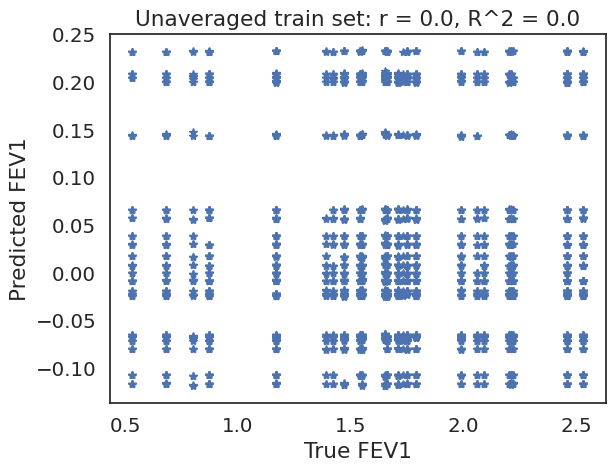

In [ ]:
# Train set performance
y_true = np.concatenate(y_train_fev1_true)
y_predicted = np.concatenate(y_train_fev1_pred)
visualize_results(y_true,y_predicted,'Unaveraged train set')

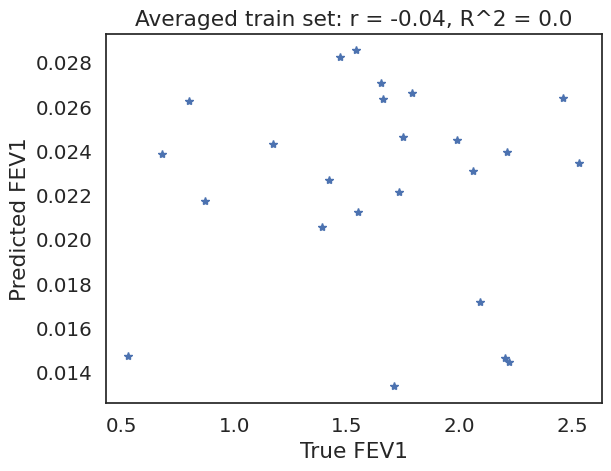

In [ ]:
# Train performance per subject
# Per subject performance
y_true = get_subj_fev1(np.concatenate(y_train_fev1_true),np.concatenate(y_train_subj_pred))
y_predicted = get_subj_fev1(np.concatenate(y_train_fev1_pred),np.concatenate(y_train_subj_pred))
visualize_results(y_true,y_predicted,'Averaged train set')

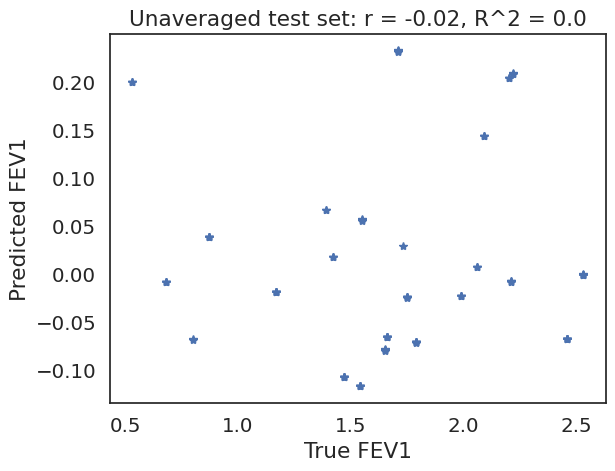

In [ ]:
# Test set performance
y_true = y_test_fev
y_predicted = y_test_fev1_pred
visualize_results(y_true,y_predicted,'Unaveraged test set')

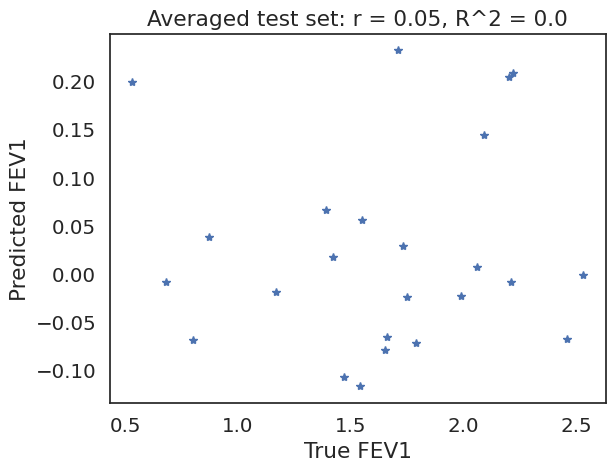

In [ ]:
# Test performance per subject
# Per subject performance
y_true = get_subj_fev1(y_test_fev,y_test_subj) # np.genfromtxt(modelpath+'240129_231621fev1_loso_fold_y_test_predicted.csv',delimiter=',')
y_predicted = get_subj_fev1(y_test_fev1_pred,y_test_subj)

visualize_results(y_true,y_predicted,'Averaged test set')

# HeartFEV1 System

